In [2]:
import torch
import string
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from train import TransducerLoss, unshear, shear, logsumexp, inf, mask
import tinygrad
from tinygrad.dtype import dtypes
from tinygrad import Tensor
from tinygrad.tensor import Function
from utils import imshow

ram used:  0.18 GB, joint.l2.bias                                     : 100%|██████████| 33/33 [00:00<00:00, 617.12it/s]


loaded weights in  65.04 ms, 0.18 GB loaded at 2.79 GB/s


ram used:  0.36 GB, joint.l2.bias                                     : 100%|██████████| 33/33 [00:00<00:00, 1103.60it/s]


loaded weights in  31.64 ms, 0.18 GB loaded at 5.72 GB/s


In [4]:
NULL_INDEX = -1
VOCAB_SIZE = len(string.ascii_lowercase) + 2
np.random.seed(0)
maxX = 10
maxY = 12
BS = 2
np_d = np.random.rand(BS, maxX, maxY+1, VOCAB_SIZE+1)
# np_y = np.random.randint(0, VOCAB_SIZE, (BS, maxY), dtype=np.int64)
np_y = np.zeros((BS, maxY), dtype=np.int64)

T = [maxX,maxX - 3]
U = [maxY,maxY - 3]


### torch model

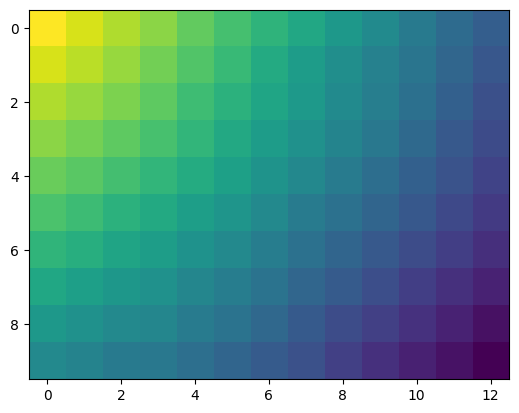

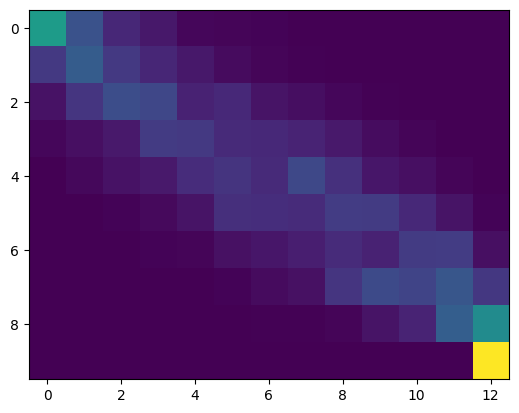

tensor([-61.8367, -44.7189], grad_fn=<StackBackward0>)

In [5]:
#torch
def compute_forward_prob(joiner_out, T, U, y):
  """
  joiner_out: tensor of shape (B, T_max, U_max+1, #labels)
  T: list of input lengths
  U: list of output lengths 
  y: label tensor (B, U_max+1)
  """
  B = joiner_out.shape[0]
  T_max = joiner_out.shape[1]
  U_max = joiner_out.shape[2] - 1
  log_alpha = torch.zeros(B, T_max, U_max+1)
  for t in range(T_max):
    for u in range(U_max+1):
      if u == 0:
        if t == 0:
          log_alpha[:, t, u] = 0.

        else: #t > 0
          log_alpha[:, t, u] = log_alpha[:, t-1, u] + joiner_out[:, t-1, 0, NULL_INDEX] 
              
      else: #u > 0
        if t == 0:
          log_alpha[:, t, u] = log_alpha[:, t,u-1] + torch.gather(joiner_out[:, t, u-1], dim=1, index=y[:,u-1].view(-1,1) ).reshape(-1)
        
        else: #t > 0
          log_alpha[:, t, u] = torch.logsumexp(torch.stack([
              log_alpha[:, t-1, u] + joiner_out[:, t-1, u, NULL_INDEX],
              log_alpha[:, t, u-1] + torch.gather(joiner_out[:, t, u-1], dim=1, index=y[:,u-1].view(-1,1) ).reshape(-1)
          ]), dim=0)
  
  log_probs = []
  for b in range(B):
    log_prob = log_alpha[b, T[b]-1, U[b]] + joiner_out[b, T[b]-1, U[b], NULL_INDEX]
    log_probs.append(log_prob)
  log_probs = torch.stack(log_probs) 
  return log_probs, log_alpha
torch_d = torch.Tensor(np_d).softmax(-1)
torch_d.requires_grad = True

y = torch.Tensor(np_y).long()
torch_loss,alpha = compute_forward_prob(torch_d.log(), T, U, y)

plt.imshow(alpha[0].detach())
plt.show()
alpha.retain_grad()
torch_loss.retain_grad()
(torch_loss.sum()).backward()

plt.imshow(torch_d.grad[0,:,:,-1])
plt.show()
torch_loss

### tinygrad model

In [6]:
def stack(X):
    R = X[0].unsqueeze(1)
    for x in X[1:]:
        R = R.cat(x.unsqueeze(1), dim=1).realize()
    return unshear(R.transpose(1,2)).transpose(1,2)

def analysis():
    global A, B, AB, skip, p
    A = stack(ctx.a).realize()
    B = stack(ctx.b).realize()
    AB = A[0] + B[0]
    AB = AB - AB.max()
    skip = unshear(ctx.skip.transpose(1,2)).transpose(1,2).realize()
    p = unshear(ctx.p.transpose(1,2)).transpose(1,2).realize()

In [7]:

class TransducerLoss(Function):

  def forward(self, d:Tensor, labels:Tensor):
    self.BS,self.X,self.Y,self.C = d.shape

    self.labels = Tensor(labels).pad(((0,0),(0,1)))
    self.lattice = shear(Tensor(d), 0.)
    self.X = self.X+self.Y-1
    assert self.lattice.shape == (self.BS,self.X,self.Y,self.C), f"{self.lattice.shape}"

    self.skip = shear(Tensor(d)[:,:,:,-1:],1.)[:,:,:,0].log()

    self.p = self.lattice[
      Tensor(np.arange(self.BS).reshape((-1,1,1))),
      Tensor(np.arange(self.X).reshape((1,-1,1))),
      Tensor(np.arange(self.Y).reshape((1,1,-1))),
      self.labels.reshape((self.BS,1,-1))].log()

    assert self.p.shape == (self.BS, self.X, self.Y)
    self.a = [Tensor([0]*self.BS).reshape(-1,1).pad(((0,0),(0,self.Y-1),),-inf).realize()]

    for x in range(0,self.X-1):
      self.a.append(logsumexp(
        (self.a[-1] + self.skip[:,x,:]).realize(),
        (
          self.a[-1][:,:-1].pad(((0,0),(1,0),),-inf).realize() + self.p[:,x,:-1].pad(((0,0),(1,0),),-inf)
        ).realize()
      ))

    return (-self.a[-1].max(1).sum()).lazydata
    
  def backward(self, g):

    self.b = [None] * (self.X-1) + [Tensor.ones(self.BS,self.Y)]
    for x in range(self.X-2,-1,-1):
      self.b[x] = (
        logsumexp(
          self.b[x+1] + self.skip[:,x,:],
          self.b[x+1][:,1:].pad(((0,0),(0,1),),-inf).realize() + self.p[:,x,:].realize()
        )).realize()

    self.skg, self.p_grad = None, None

    for a,b in zip(self.a[:-1], self.b[1:]):
      sg = (a + b).reshape(self.BS, 1,-1)
      self.skg = sg if self.skg is None else self.skg.cat(sg,dim=1).realize()
      pg = a.unsqueeze(1) + b[:,1:].pad(((0,0),(0,1),),-inf).unsqueeze(1)
      self.p_grad = pg if self.p_grad is None else self.p_grad.cat(pg,dim=1).realize()
    
    self.skg = (unshear(self.skg.transpose(1,2)) - self.b[0][:,0].unsqueeze(1).unsqueeze(1)).transpose(1,2).exp().realize()
    self.p_grad = (unshear(self.p_grad.transpose(1,2))).transpose(1,2).realize() - self.b[0][:,0].unsqueeze(1).unsqueeze(1)

    self.p_grad = self.p_grad.exp().unsqueeze(-1).mul(Tensor.eye(self.C-1)[self.labels].unsqueeze(1))
    grad = self.p_grad.cat(self.skg.unsqueeze(-1), dim=-1).pad(((0,0),(0,1),(0,0),(0,0)))

    return (-grad).lazydata, None

tiny_d = tinygrad.Tensor(np_d, requires_grad=True, dtype=dtypes.float).softmax(-1)
tiny_masked_d = mask(tiny_d, tinygrad.Tensor(T), tinygrad.Tensor(U),maxX,maxY)
tiny_y = tinygrad.Tensor(np_y, requires_grad=False, dtype=dtypes.int)
L = TransducerLoss.apply(tiny_masked_d,tiny_y)
ctx = L._ctx
L.backward()
L.numpy()
analysis()

In [8]:
A.numpy()[0,:10,:10]

array([[  0.       ,  -3.4432669,  -6.885416 , -10.2300205, -14.04884  ,
        -17.130007 , -20.352547 , -23.432203 , -27.170334 , -30.518944 ],
       [ -3.470232 ,  -6.0249853,  -9.0918255, -12.343253 , -15.795076 ,
        -19.102194 , -22.60842  , -26.071495 , -29.464403 , -32.66238  ],
       [ -6.9761925,  -9.083638 , -11.528527 , -14.556755 , -18.02709  ,
        -20.791246 , -24.062757 , -27.026957 , -30.408558 , -33.315346 ],
       [-10.083391 , -12.12846  , -14.445574 , -17.031837 , -19.929716 ,
        -23.181038 , -26.011057 , -28.856197 , -31.97736  , -35.052765 ],
       [-13.330563 , -14.89034  , -17.382233 , -19.99925  , -22.501871 ,
        -25.295643 , -28.366392 , -31.115198 , -34.178577 , -37.294758 ],
       [-16.596333 , -18.376287 , -20.77765  , -22.887959 , -25.591965 ,
        -27.928421 , -30.889193 , -34.068134 , -36.697926 , -39.421387 ],
       [-20.27086  , -21.84678  , -24.344769 , -25.800253 , -28.58327  ,
        -30.908514 , -33.677975 , -36.592888 

In [9]:
alpha.detach().numpy()[0,:10,:10]

array([[  0.       ,  -3.4432669,  -6.885416 , -10.2300205, -14.04884  ,
        -17.130007 , -20.352547 , -23.432203 , -27.170334 , -30.518944 ],
       [ -3.470232 ,  -6.0249853,  -9.0918255, -12.343253 , -15.795076 ,
        -19.102194 , -22.60842  , -26.071495 , -29.464403 , -32.66238  ],
       [ -6.9761925,  -9.083638 , -11.528527 , -14.556755 , -18.02709  ,
        -20.791246 , -24.062757 , -27.026957 , -30.408558 , -33.315346 ],
       [-10.083391 , -12.12846  , -14.445574 , -17.031837 , -19.929716 ,
        -23.181038 , -26.011057 , -28.856197 , -31.97736  , -35.052765 ],
       [-13.330563 , -14.89034  , -17.382233 , -19.99925  , -22.501871 ,
        -25.295643 , -28.366392 , -31.115198 , -34.178577 , -37.294758 ],
       [-16.596333 , -18.376287 , -20.77765  , -22.887959 , -25.591967 ,
        -27.928423 , -30.889194 , -34.068134 , -36.697926 , -39.421387 ],
       [-20.27086  , -21.84678  , -24.344769 , -25.800253 , -28.583271 ,
        -30.908516 , -33.67798  , -36.592888 

In [13]:
torch_d.grad.numpy()[0,:10,:10,-1]

array([[1.74961929e+01, 7.97964287e+00, 3.56664610e+00, 1.99101460e+00,
        6.14948809e-01, 4.34167475e-01, 2.56130219e-01, 9.63766128e-02,
        2.17967331e-02, 1.07900174e-02],
       [5.26216936e+00, 9.24175739e+00, 5.22799635e+00, 3.44640493e+00,
        2.00747108e+00, 9.06265616e-01, 4.83429343e-01, 1.49318397e-01,
        5.98739460e-02, 2.50106212e-02],
       [1.52423358e+00, 4.90148067e+00, 7.55432320e+00, 6.83039522e+00,
        3.09769225e+00, 3.68203974e+00, 1.73709154e+00, 1.13893712e+00,
        5.21500707e-01, 2.29328066e-01],
       [5.85915267e-01, 1.33170760e+00, 2.21861863e+00, 5.57264996e+00,
        5.31968451e+00, 3.79864979e+00, 3.65959573e+00, 3.15624166e+00,
        2.17828584e+00, 1.05242300e+00],
       [8.69041681e-02, 6.41965449e-01, 1.49377215e+00, 2.23314476e+00,
        4.09100437e+00, 4.74601221e+00, 3.79470634e+00, 6.90322828e+00,
        4.40865755e+00, 1.87655890e+00],
       [3.21551561e-02, 1.08442597e-01, 3.54405701e-01, 8.17866802e-01,
   

In [15]:
tiny_d.grad.numpy()[0,:10,:10,-1]

array([[-1.74961414e+01, -7.97960520e+00, -3.56663179e+00,
        -1.99101460e+00, -6.14947975e-01, -4.34166253e-01,
        -2.56130487e-01, -9.63765085e-02, -2.17967071e-02,
        -1.07899867e-02],
       [-5.26213932e+00, -9.24172115e+00, -5.22796535e+00,
        -3.44639063e+00, -2.00747252e+00, -9.06261981e-01,
        -4.83428180e-01, -1.49318099e-01, -5.98739609e-02,
        -2.50106435e-02],
       [-1.52422476e+00, -4.90146780e+00, -7.55430508e+00,
        -6.83037138e+00, -3.09767985e+00, -3.68203950e+00,
        -1.73708403e+00, -1.13892949e+00, -5.21499574e-01,
        -2.29327798e-01],
       [-5.85912943e-01, -1.33170092e+00, -2.21861386e+00,
        -5.57261753e+00, -5.31966066e+00, -3.79863000e+00,
        -3.65957856e+00, -3.15623450e+00, -2.17827630e+00,
        -1.05241776e+00],
       [-8.69039893e-02, -6.41964614e-01, -1.49376881e+00,
        -2.23313355e+00, -4.09100485e+00, -4.74599266e+00,
        -3.79470491e+00, -6.90321827e+00, -4.40863991e+00,
        -1.